In [ ]:
%load_ext autoreload
%autoreload 2
import os
prefix = ''
if os.path.expanduser('~') == '/home/baraldian': # UNI env
    prefix = '/home/baraldian'
else:
    from google.colab import drive
    drive.mount('/content/drive')
softlab_path = os.path.join(prefix + '/content/drive/Shareddrives/SoftLab/')
project_path = os.path.join(softlab_path, 'Projects', 'Fairness','scalable-fairlearn')
import sys
sys.path.append(os.path.join(project_path))
sys.path = list(set(sys.path))

exec(open(os.path.join(project_path,'notebook_import_utility_env.py')).read())

base_dir = os.path.join(project_path,"results","yeeha","adult")

In [ ]:
import os
import json
import numpy as np

from collections import defaultdict 

import numpy as np
from scipy.stats import norm, t, sem

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def mean_confidence_interval(data, confidence=0.95):
    if data is None:
        return [np.nan, np.nan, np.nan]
    
    a = np.asarray(data).astype(float)
    n = len(a)
    m, se = np.nanmean(a), sem(a, nan_policy="omit", ddof=1)
    h1 = m + se * t.ppf((1.0 - confidence) / 2., n - 1)
    h2 = m + se * t.ppf((1.0 + confidence) / 2., n - 1)
    return np.array([m, h1, h2])


def get_combined_hybrid(train_err_hybrids, train_vio_hybrids, alpha):
    # alpha = importance of error vs. violation
    
    n = len(train_err_hybrids)
    if len(train_vio_hybrids) != n:
        raise Exception()
    
    scores = [
        alpha * train_err_hybrids[i] + (1 - alpha) * train_vio_hybrids[i]
        for i in range(n)
    ]
    
    best_index = scores.index(min(scores))
    
    return best_index

def read_unmitigated_results(unmitigated_results_file_name):
    if not os.path.exists(unmitigated_results_file_name):
        time_unmitigated = None
        train_error_unmitigated = None
        train_violation_unmitigated = None
        test_error_unmitigated = None
        test_violation_unmitigated = None
    
    else:
        with open(unmitigated_results_file_name, 'r') as _file:
            unmitigated_results = json.load(_file)

        time_unmitigated = unmitigated_results["time_unmitigated"]
        train_error_unmitigated = unmitigated_results["train_error_unmitigated"]
        train_violation_unmitigated = unmitigated_results["train_vio_unmitigated"]
        test_error_unmitigated = unmitigated_results["test_error_unmitigated"]
        test_violation_unmitigated = unmitigated_results["test_vio_unmitigated"]

    return {
        "time": mean_confidence_interval(time_unmitigated),
        "train-error": mean_confidence_interval(train_error_unmitigated),
        "train-violation": mean_confidence_interval(train_violation_unmitigated),
        "test-error": mean_confidence_interval(test_error_unmitigated),
        "test-violation": mean_confidence_interval(test_violation_unmitigated),
    }

def read_fairlearn_results(fairlearn_results_file_name):
    if not os.path.exists(fairlearn_results_file_name):
        return {
            "time": mean_confidence_interval(None),
            "train-error": mean_confidence_interval(None),
            "train-violation": mean_confidence_interval(None),
            "test-error": mean_confidence_interval(None),
            "test-violation": mean_confidence_interval(None),
        }
    
    with open(fairlearn_results_file_name, 'r') as _file:
        fairlearn_results = json.load(_file)
        time_expgrad_all = fairlearn_results["time_expgrad_all"]
        train_error_expgrad_all = fairlearn_results["train_error_expgrad_all"]
        train_violation_expgrad_all = fairlearn_results["train_vio_expgrad_all"]
        test_error_expgrad_all = fairlearn_results["test_error_expgrad_all"]
        test_violation_expgrad_all = fairlearn_results["test_vio_expgrad_all"]
        return {
            "time": mean_confidence_interval(time_expgrad_all),
            "train-error": mean_confidence_interval(train_error_expgrad_all),
            "train-violation": mean_confidence_interval(train_violation_expgrad_all),
            "test-error": mean_confidence_interval(test_error_expgrad_all),
            "test-violation": mean_confidence_interval(test_violation_expgrad_all),
        }

def read_hybrids_results(hybrid_results_file_name):
    if os.path.exists(hybrid_results_file_name):
        hybrid_results = json.load(open(hybrid_results_file_name, 'r'))
    else:
        hybrid_results = [{}]
    
    fractions = np.full((1, 3), np.nan)
    grid_fractions = np.full((1, 3), np.nan)
    
    time_expgrad_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
    time_hybrid1_ci = np.full((len(hybrid_results), 3), np.nan)
    time_hybrid2_ci = np.full((len(hybrid_results), 3), np.nan)
    time_hybrid3_ci = np.full((len(hybrid_results), 3), np.nan)
    time_hybrid4_ci = np.full((len(hybrid_results), 3), np.nan)
    time_hybrid5_ci = np.full((len(hybrid_results), 3), np.nan)
    time_hybrid_combo_ci = np.full((len(hybrid_results), 3), np.nan)
    time_unmitigated_ci = np.full((len(hybrid_results), 3), np.nan)
    time_expgrad_alls_ci = np.full((len(hybrid_results), 3), np.nan)

    # baselines
    train_error_expgrad_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
    train_error_expgrad_alls_ci = np.full((len(hybrid_results), 3), np.nan)
    train_error_unmitigated_ci = np.full((len(hybrid_results), 3), np.nan)

    train_vio_expgrad_alls_ci = np.full((len(hybrid_results), 3), np.nan)
    train_vio_expgrad_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
    train_vio_unmitigated_ci = np.full((len(hybrid_results), 3), np.nan)

    test_error_expgrad_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
    test_error_expgrad_alls_ci = np.full((len(hybrid_results), 3), np.nan)
    test_error_unmitigated_ci = np.full((len(hybrid_results), 3), np.nan)

    test_vio_expgrad_alls_ci = np.full((len(hybrid_results), 3), np.nan)
    test_vio_expgrad_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
    test_vio_unmitigated_ci = np.full((len(hybrid_results), 3), np.nan)

    # Hybrid 1
    train_error_hybrids_ci = np.full((len(hybrid_results), 3), np.nan)
    train_vio_hybrids_ci = np.full((len(hybrid_results), 3), np.nan)
    test_error_hybrids_ci = np.full((len(hybrid_results), 3), np.nan)
    test_vio_hybrids_ci = np.full((len(hybrid_results), 3), np.nan)

    # Hybrid 2
    train_error_grid_pmf_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
    train_vio_grid_pmf_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
    test_error_grid_pmf_fracs_ci = np.full((len(hybrid_results), 3), np.nan)
    test_vio_grid_pmf_fracs_ci = np.full((len(hybrid_results), 3), np.nan)

    # Hybrid 3
    train_vio_rewts_pmf_ci = np.full((len(hybrid_results), 3), np.nan)
    train_error_rewts_pmf_ci = np.full((len(hybrid_results), 3), np.nan)
    test_vio_rewts_pmf_ci = np.full((len(hybrid_results), 3), np.nan)
    test_error_rewts_pmf_ci = np.full((len(hybrid_results), 3), np.nan)

    # Hybrid 4
    train_error_rewts_partial_ci = np.full((len(hybrid_results), 3), np.nan)
    train_vio_rewts_partial_ci = np.full((len(hybrid_results), 3), np.nan)
    test_error_rewts_partial_ci = np.full((len(hybrid_results), 3), np.nan)
    test_vio_rewts_partial_ci = np.full((len(hybrid_results), 3), np.nan)

    # Hybrid 5
    train_error_no_grid_rewts_ci = np.full((len(hybrid_results), 3), np.nan)
    train_vio_no_grid_rewts_ci = np.full((len(hybrid_results), 3), np.nan)
    test_error_no_grid_rewts_ci = np.full((len(hybrid_results), 3), np.nan)
    test_vio_no_grid_rewts_ci = np.full((len(hybrid_results), 3), np.nan)

    # Hybrid Combined
    train_err_combo_ci = {alpha: np.full((len(hybrid_results), 3), np.nan) for alpha in alphas}
    train_vio_combo_ci = {alpha: np.full((len(hybrid_results), 3), np.nan) for alpha in alphas}
    test_err_combo_ci = {alpha: np.full((len(hybrid_results), 3), np.nan) for alpha in alphas}
    test_vio_combo_ci = {alpha: np.full((len(hybrid_results), 3), np.nan) for alpha in alphas}

    for i, r in enumerate(hybrid_results):
        if r == {}:
            continue
        
        f = r["frac"]
        grid_f = r["grid_frac"]

        _time_expgrad_fracs = r["_time_expgrad_fracs"]
        _time_hybrid1 = r["_time_hybrid1"]
        _time_hybrid2 = r["_time_hybrid2"]
        _time_hybrid3 = r["_time_hybrid3"]
        _time_hybrid4 = r["_time_hybrid4"]
        _time_hybrid5 = r["_time_hybrid5"]
        _time_combo = r["_time_combined"]

        _train_error_expgrad_fracs = r["_train_error_expgrad_fracs"]
        _train_vio_expgrad_fracs = r["_train_vio_expgrad_fracs"]
        _train_error_hybrids = r["_train_error_hybrids"]
        _train_vio_hybrids = r["_train_vio_hybrids"]
        _train_error_grid_pmf_fracs = r["_train_error_grid_pmf_fracs"]
        _train_vio_grid_pmf_fracs = r["_train_vio_grid_pmf_fracs"]
        _train_error_rewts = r["_train_error_rewts"]
        _train_vio_rewts = r["_train_vio_rewts"]
        _train_error_rewts_partial = r["_train_error_rewts_partial"]
        _train_vio_rewts_partial = r["_train_vio_rewts_partial"]
        _train_error_no_grid_rewts = r["_train_error_no_grid_rewts"]
        _train_vio_no_grid_rewts = r["_train_vio_no_grid_rewts"]

        _train_err_combined = {alpha: [None for i in range(len(_time_combo))] for alpha in alphas}
        _train_vio_combined = {alpha: [None for i in range(len(_time_combo))] for alpha in alphas}

        _test_error_expgrad_fracs = r["_test_error_expgrad_fracs"]
        _test_vio_expgrad_fracs = r["_test_vio_expgrad_fracs"]
        _test_error_hybrids = r["_test_error_hybrids"]
        _test_vio_hybrids = r["_test_vio_hybrids"]
        _test_error_grid_pmf_fracs = r["_test_error_grid_pmf_fracs"]
        _test_vio_grid_pmf_fracs = r["_test_vio_grid_pmf_fracs"]
        _test_error_rewts = r["_test_error_rewts"]
        _test_vio_rewts = r["_test_vio_rewts"]
        _test_error_rewts_partial = r["_test_error_rewts_partial"]
        _test_vio_rewts_partial = r["_test_vio_rewts_partial"]
        _test_error_no_grid_rewts = r["_test_error_no_grid_rewts"]
        _test_vio_no_grid_rewts = r["_test_vio_no_grid_rewts"]

        _test_err_combined = {alpha: [None for i in range(len(_time_combo))] for alpha in alphas}
        _test_vio_combined = {alpha: [None for i in range(len(_time_combo))] for alpha in alphas}

        # CONSTRUCT COMBINED
        for j in range(len(_train_error_hybrids)):
            __train_err_hybrids = [_train_error_no_grid_rewts[j], _train_error_rewts[j]]
            __train_vio_hybrids = [_train_vio_no_grid_rewts[j], _train_vio_rewts[j]]
            __test_err_hybrids = [_test_error_no_grid_rewts[j], _test_error_rewts[j]]
            __test_vio_hybrids = [_test_vio_no_grid_rewts[j], _test_vio_rewts[j]]
            for alpha in alphas:
                best_index = get_combined_hybrid(__train_err_hybrids, __train_vio_hybrids, alpha=alpha)
                # Set combined train
                _train_err_combined[alpha][j] = __train_err_hybrids[best_index]
                _train_vio_combined[alpha][j] = __train_vio_hybrids[best_index]
                # Set combined test
                _test_err_combined[alpha][j] = __test_err_hybrids[best_index]
                _test_vio_combined[alpha][j] = __test_vio_hybrids[best_index]

        fractions[i] = f
        grid_fractions[i] = grid_f

#             time_expgrad_alls_ci[i] = mean_confidence_interval(time_expgrad_all)
#             time_unmitigated_ci[i] = mean_confidence_interval(time_unmitigated)
        time_expgrad_fracs_ci[i] = mean_confidence_interval(_time_expgrad_fracs)

        time_hybrid1_ci[i] = mean_confidence_interval(_time_hybrid1)
        time_hybrid2_ci[i] = mean_confidence_interval(_time_hybrid2)
        time_hybrid3_ci[i] = mean_confidence_interval(_time_hybrid3)
        time_hybrid4_ci[i] = mean_confidence_interval(_time_hybrid4)
        time_hybrid5_ci[i] = mean_confidence_interval(_time_hybrid5)
        time_hybrid_combo_ci[i] = mean_confidence_interval(_time_combo)

        # baseline
#             train_error_expgrad_alls_ci[i] = mean_confidence_interval(train_error_expgrad_all)
#             train_error_unmitigated_ci[i] = mean_confidence_interval(train_error_unmitigated)

#             train_vio_expgrad_alls_ci[i] = mean_confidence_interval(train_violation_expgrad_all)
#             train_vio_unmitigated_ci[i] = mean_confidence_interval(train_violation_unmitigated)

#             test_error_expgrad_alls_ci[i] = mean_confidence_interval(test_error_expgrad_all)
#             test_error_unmitigated_ci[i] = mean_confidence_interval(test_error_unmitigated)

#             test_vio_expgrad_alls_ci[i] = mean_confidence_interval(test_violation_expgrad_all)
#             test_vio_unmitigated_ci[i] = mean_confidence_interval(test_violation_unmitigated)

        # exp frac
        train_error_expgrad_fracs_ci[i] = mean_confidence_interval(_train_error_expgrad_fracs)
        train_vio_expgrad_fracs_ci[i] = mean_confidence_interval(_train_vio_expgrad_fracs)

        test_error_expgrad_fracs_ci[i] = mean_confidence_interval(_test_error_expgrad_fracs)
        test_vio_expgrad_fracs_ci[i] = mean_confidence_interval(_test_vio_expgrad_fracs)

        # Hybrid 1
        train_error_hybrids_ci[i] = mean_confidence_interval(_train_error_hybrids)
        train_vio_hybrids_ci[i] = mean_confidence_interval(_train_vio_hybrids)

        test_error_hybrids_ci[i] = mean_confidence_interval(_test_error_hybrids)
        test_vio_hybrids_ci[i] = mean_confidence_interval(_test_vio_hybrids)

        # Hybrid 2
        train_error_grid_pmf_fracs_ci[i] = mean_confidence_interval(_train_error_grid_pmf_fracs)
        train_vio_grid_pmf_fracs_ci[i] = mean_confidence_interval(_train_vio_grid_pmf_fracs)

        test_error_grid_pmf_fracs_ci[i] = mean_confidence_interval(_test_error_grid_pmf_fracs)
        test_vio_grid_pmf_fracs_ci[i] = mean_confidence_interval(_test_vio_grid_pmf_fracs)

        # Hybrid 3: re-weight using LP
        train_error_rewts_pmf_ci[i] = mean_confidence_interval(_train_error_rewts)
        train_vio_rewts_pmf_ci[i] = mean_confidence_interval(_train_vio_rewts)

        test_error_rewts_pmf_ci[i] = mean_confidence_interval(_test_error_rewts)
        test_vio_rewts_pmf_ci[i] = mean_confidence_interval(_test_vio_rewts)

        # Hybrid 4
        train_error_rewts_partial_ci[i] = mean_confidence_interval(_train_error_rewts_partial)
        train_vio_rewts_partial_ci[i] = mean_confidence_interval(_train_vio_rewts_partial)

        test_error_rewts_partial_ci[i] = mean_confidence_interval(_test_error_rewts_partial)
        test_vio_rewts_partial_ci[i] = mean_confidence_interval(_test_vio_rewts_partial)

        # Hybrid 5
        train_error_no_grid_rewts_ci[i] = mean_confidence_interval(_train_error_no_grid_rewts)
        train_vio_no_grid_rewts_ci[i] = mean_confidence_interval(_train_vio_no_grid_rewts)

        test_error_no_grid_rewts_ci[i] = mean_confidence_interval(_test_error_no_grid_rewts)
        test_vio_no_grid_rewts_ci[i] = mean_confidence_interval(_test_vio_no_grid_rewts)

        # Hybrid combined
        for alpha in alphas:
            train_err_combo_ci[alpha][i] = mean_confidence_interval(_train_err_combined[alpha])
            train_vio_combo_ci[alpha][i] = mean_confidence_interval(_train_vio_combined[alpha])

            test_err_combo_ci[alpha][i] = mean_confidence_interval(_test_err_combined[alpha])
            test_vio_combo_ci[alpha][i] = mean_confidence_interval(_test_vio_combined[alpha])
    
#     else:
#         fractions = np.full((1, 3), np.nan)
#         grid_fractions = np.full((1, 3), np.nan)
#         time_expgrad_fracs_ci = np.full((1, 3), np.nan)
#         time_expgrad_fracs_ci = np.full((1, 3), np.nan)
#         time_hybrid1_ci = np.full((1, 3), np.nan)
#         time_hybrid2_ci = np.full((1, 3), np.nan)
#         time_hybrid3_ci = np.full((1, 3), np.nan)
#         time_hybrid4_ci = np.full((1, 3), np.nan)
#         time_hybrid5_ci = np.full((1, 3), np.nan)
#         time_hybrid_combo_ci = np.full((1, 3), np.nan)
#         train_error_expgrad_fracs_ci = np.full((1, 3), np.nan)
    
    print(grid_fractions)
    
    return {
        "fractions": fractions,
        "grid_fractions": grid_fractions,
        "fairlearn_on_subsample": {
            "times": time_expgrad_fracs_ci,
            "train_errors": train_error_expgrad_fracs_ci,
            "train_violations": train_vio_expgrad_fracs_ci,
            "test_errors": test_error_expgrad_fracs_ci,
            "test_violations": test_vio_expgrad_fracs_ci,
        },
        "hybrid_1": {
            "times": time_hybrid1_ci,
            "train_errors": train_error_hybrids_ci,
            "train_violations": train_vio_hybrids_ci,
            "test_errors": test_error_hybrids_ci,
            "test_violations": test_vio_hybrids_ci,
        },
        "hybrid_2": {
            "times": time_hybrid2_ci,
            "train_errors": train_error_grid_pmf_fracs_ci,
            "train_violations": train_vio_grid_pmf_fracs_ci,
            "test_errors": test_error_grid_pmf_fracs_ci,
            "test_violations": test_vio_grid_pmf_fracs_ci,
        },
        "hybrid_3": {
            "times": time_hybrid3_ci,
            "train_errors": train_error_rewts_pmf_ci,
            "train_violations": train_vio_rewts_pmf_ci,
            "test_errors": test_error_rewts_pmf_ci,
            "test_violations": test_vio_rewts_pmf_ci,
        },
        "hybrid_4": {
            "times": time_hybrid4_ci,
            "train_errors": train_error_rewts_partial_ci,
            "train_violations": train_vio_rewts_partial_ci,
            "test_errors": test_error_rewts_partial_ci,
            "test_violations": test_vio_rewts_partial_ci,
        },
        "hybrid_5": {
            "times": time_hybrid5_ci,
            "train_errors": train_error_no_grid_rewts_ci,
            "train_violations": train_vio_no_grid_rewts_ci,
            "test_errors": test_error_no_grid_rewts_ci,
            "test_violations": test_vio_no_grid_rewts_ci,
        },
        "hybrid_combo": {
            "times": time_hybrid_combo_ci,
            "train_errors": train_err_combo_ci,
            "train_violations": train_vio_combo_ci,
            "test_errors": test_err_combo_ci,
            "test_violations": test_vio_combo_ci,
        },
    }

In [ ]:

result_file_names = {
    10000: {
        "unmitigated": "2021-02-23_07-02-30_unmitigated.json",
        "fairlearn": "2021-02-23_07-03-19_fairlearn_e0.05.json",
        "hybrids": [
            "2021-02-23_07-05-29_hybrids_e0.05_g0.5.json", 
            "2021-02-24_08-55-22_hybrids_e0.05_g0.2.json",
            "2021-02-24_09-10-41_hybrids_e0.05_g0.1.json",
        ],
    },
    100000: {
        "unmitigated": "2021-02-24_05-41-01_unmitigated.json",
        "fairlearn": "2021-02-23_09-37-14_fairlearn_e0.05.json",
        "hybrids": [
            "2021-02-23_07-19-34_hybrids_e0.05_g0.5.json", 
            "2021-02-24_08-54-44_hybrids_e0.05_g0.2.json",
            "2021-02-24_09-12-38_hybrids_e0.05_g0.1.json",
        ],
    },
    1000000: {
        "unmitigated": "2021-02-24_05-41-18_unmitigated.json",
        "fairlearn": "2021-02-23_11-03-09_fairlearn_e0.05.json",
        "hybrids": [
            "2021-02-23_10-46-25_hybrids_e0.05_g0.5.json", 
            "2021-02-24_06-04-24_hybrids_e0.05_g0.2.json",
            "2021-02-24_09-25-47_hybrids_e0.05_g0.1.json",
        ],
    },
    10000000: {
        "unmitigated": None,
        "fairlearn": None,
        "hybrids": [
            None, 
            None,
            "2021-02-24_12-01-21_hybrids_e0.05_g0.1.json",
        ],
    },
}

data_sizes = result_file_names.keys()
data_sizes

dict_keys([10000, 100000, 1000000, 10000000])

In [ ]:
# Alpha = Importance of error (vs. violation)
# alphas = [0.05]  # , 0.5, 0.95]
alphas = [0.5]  # , 0.5, 0.95]

result_file_names = {
    10000: {
        "unmitigated": "2021-02-23_07-02-30_unmitigated.json",
        "fairlearn": "2021-02-23_07-03-19_fairlearn_e0.05.json",
        "hybrids": [
            "2021-02-23_07-05-29_hybrids_e0.05_g0.5.json", 
            "2021-02-24_08-55-22_hybrids_e0.05_g0.2.json",
            "2021-02-24_09-10-41_hybrids_e0.05_g0.1.json",
        ],
    },
    100000: {
        "unmitigated": "2021-02-24_05-41-01_unmitigated.json",
        "fairlearn": "2021-02-23_09-37-14_fairlearn_e0.05.json",
        "hybrids": [
            "2021-02-23_07-19-34_hybrids_e0.05_g0.5.json", 
            "2021-02-24_08-54-44_hybrids_e0.05_g0.2.json",
            "2021-02-24_09-12-38_hybrids_e0.05_g0.1.json",
        ],
    },
    1000000: {
        "unmitigated": "2021-02-24_05-41-18_unmitigated.json",
        "fairlearn": "2021-02-23_11-03-09_fairlearn_e0.05.json",
        "hybrids": [
            "2021-02-23_10-46-25_hybrids_e0.05_g0.5.json", 
            "2021-02-24_06-04-24_hybrids_e0.05_g0.2.json",
            "2021-02-24_09-25-47_hybrids_e0.05_g0.1.json",
        ],
    },
    10000000: {
        "unmitigated": None,
        "fairlearn": None,
        "hybrids": [
            None, 
            None,
            "2021-02-24_12-01-21_hybrids_e0.05_g0.1.json",
        ],
    },
}

data_sizes = result_file_names.keys()

_results = {}

for n in data_sizes:
    base_dir = f"{project_path}/results/yeeha/synth_n{n}_f3_t0.5_t00.3_t10.6_tr0.3_v1"
    unmitigated_results_file_name = f"{base_dir}/{result_file_names[n]['unmitigated']}"
    fairlearn_results_file_name = f"{base_dir}/{result_file_names[n]['fairlearn']}"
    
    unmitigated_results = read_unmitigated_results(unmitigated_results_file_name)
    fairlearn_results = read_fairlearn_results(fairlearn_results_file_name)
    hybrid_results = {}
    for i, hybrid_results_file_name in enumerate(result_file_names[n]['hybrids']):
        hybrid_results[i] = read_hybrids_results(f"{base_dir}/{hybrid_results_file_name}")
    
    _results[n] = {
        "unmitigated": unmitigated_results,
        "fairlearn": fairlearn_results,
        "hybrids": hybrid_results,
    }

results = _results

[[0.5 0.5 0.5]]
[[0.2 0.2 0.2]]
[[0.1 0.1 0.1]]
[[0.5 0.5 0.5]]
[[0.2 0.2 0.2]]
[[0.1 0.1 0.1]]
[[0.5 0.5 0.5]]
[[0.2 0.2 0.2]]
[[0.1 0.1 0.1]]
[[nan nan nan]]
[[nan nan nan]]
[[0.1 0.1 0.1]]


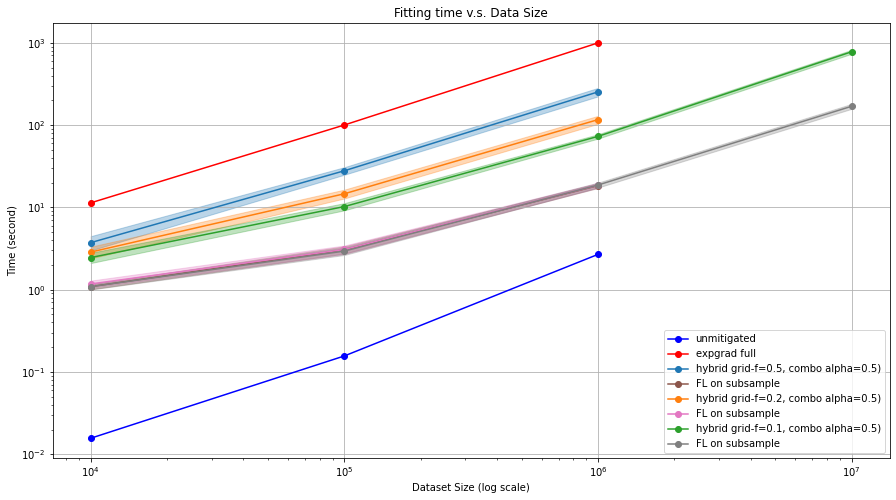

In [ ]:
# Time Plots

# grid_fractions = hybrid_results["grid_fractions"]
grid_fraction = 0.5

data = np.array([results[n]["unmitigated"].get("time") for n in results])
plt.fill_between(data_sizes, data[:,1], data[:,2], color='b', alpha=0.3)
plt.plot(data_sizes, data[:,0], 'bo-', label="unmitigated")

data = np.array([results[n]["fairlearn"].get("time") for n in results])
# print(data)
plt.fill_between(data_sizes, data[:,1], data[:,2], color='r', alpha=0.3)
plt.plot(data_sizes, data[:,0], 'ro-', label="expgrad full")

# data = np.array([results[n]["hybrids"]["hybrid_3"].get("times") for n in results])[:,0,:]
# print(data)
# plt.fill_between(data_sizes, data[:,1], data[:,2], color='k', alpha=0.3)
# plt.plot(data_sizes, data[:,0], 'ko-', label="hybrid 3 (GS + LP)")

alpha = alphas[0]
num_hybrids = 3
cols = list(mcolors.TABLEAU_COLORS.keys())
for i in range(num_hybrids):
    c = cols[i]
    grid_f = results[10000]["hybrids"][i]["grid_fractions"][0][0]
    
    data = np.array([results[n]["hybrids"][i]["hybrid_combo"]["times"] 
                     if i in results[n]["hybrids"] else np.array([[np.nan, np.nan, np.nan]])
                     for n in results])[:,0,:]
    plt.fill_between(data_sizes, data[:,1], data[:,2], color=c, alpha=0.3)
    plt.plot(data_sizes, data[:,0], c=c, marker="o", label=f"hybrid grid-f={grid_f}, combo alpha={alpha})")
    
    c = cols[5 + i]
    data = np.array([results[n]["hybrids"][i]["fairlearn_on_subsample"]["times"] 
                     if i in results[n]["hybrids"] else np.array([[np.nan, np.nan, np.nan]])
                     for n in results])[:,0,:]
    plt.fill_between(data_sizes, data[:,1], data[:,2], color=c, alpha=0.3)
    plt.plot(data_sizes, data[:,0], c=c, marker="o", label=f"FL on subsample")

plt.xlabel("Dataset Size (log scale)")
plt.ylabel("Time (second)")
plt.title("Fitting time v.s. Data Size")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 8)
plt.show()

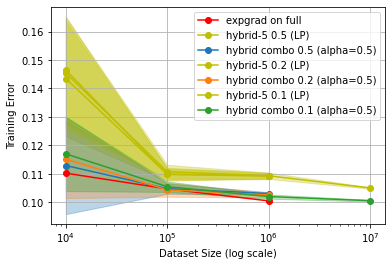

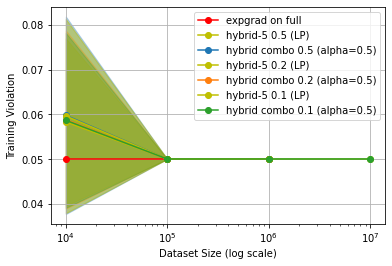

In [ ]:
cols = list(mcolors.TABLEAU_COLORS.keys())

empty = np.array([np.nan, np.nan, np.nan])

errors = {
    "expgrad_alls": ("r", "expgrad on full", 
                     np.array([results[n]["fairlearn"]["train-error"] for n in data_sizes])),
}

violations = {
    "expgrad_alls": ("r", "expgrad on full", 
                     np.array([results[n]["fairlearn"]["train-violation"] for n in data_sizes])),
}

for h in range(num_hybrids):
    grid_f = results[10000]["hybrids"][h]["grid_fractions"][0][0]
    
    errors[f"no_grid_rewts_{h}"] = ("y", f"hybrid-5 {grid_f} (LP)", 
                                    np.array([results[n]["hybrids"][h]["hybrid_5"]["train_errors"][0] 
                                              if h in results[n]["hybrids"] else empty
                                              for n in data_sizes]))

    violations[f"no_grid_rewts_{h}"] = ("y", f"hybrid-5 {grid_f} (LP)", 
                                        np.array([results[n]["hybrids"][h]["hybrid_5"]["train_violations"][0]
                                                if h in results[n]["hybrids"] else empty
                                                for n in data_sizes]))

    # Add alpha combos
    for i, alpha in enumerate(alphas):
        grid_f = results[10000]["hybrids"][h]["grid_fractions"][0][0]

        errors[f"combo_{h}[{alpha}]"] =  (cols[h * (i+1)], f"hybrid combo {grid_f} (alpha={alpha})", 
                                          np.array([results[n]["hybrids"][h]["hybrid_combo"]["train_errors"][alpha][0] 
                                                    if h in results[n]["hybrids"] else empty
                                                    for n in data_sizes]))
        violations[f"combo_{h}[{alpha}]"] = (cols[h * (i+1)], f"hybrid combo {grid_f} (alpha={alpha})", 
                                             np.array([results[n]["hybrids"][h]["hybrid_combo"]["train_violations"][alpha][0] 
                                                       if h in results[n]["hybrids"] else empty
                                                       for n in data_sizes]))

# Plot errors
for k, (c1, label, means) in errors.items():
    plt.fill_between(data_sizes, means[:,1], means[:,2], color=c1, alpha=0.3)
    plt.plot(data_sizes, means[:,0], c1, marker="o", label=label)

plt.xlabel("Dataset Size (log scale)")
plt.ylabel("Training Error")
# plt.title('Training Error v.s. Fraction')
plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

# Plot violations
for k, (c1, label, means) in violations.items():
    plt.fill_between(data_sizes, means[:,1], means[:,2], color=c1, alpha=0.3)
    plt.plot(data_sizes, means[:,0], c1, marker="o", label=label)
    
plt.xlabel("Dataset Size (log scale)")
plt.ylabel("Training Violation")
# plt.title('Training Violation v.s. Fraction')
plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

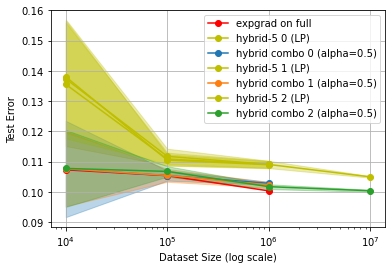

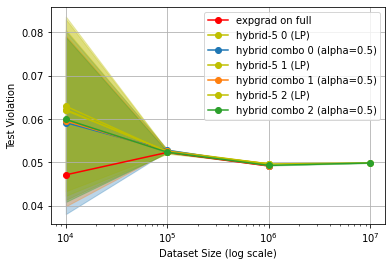

In [ ]:
errors = {
    "expgrad_alls": ("r", "expgrad on full", 
                     np.array([results[n]["fairlearn"]["test-error"] for n in data_sizes])),
}

violations = {
    "expgrad_alls": ("r", "expgrad on full", 
                     np.array([results[n]["fairlearn"]["test-violation"] for n in data_sizes])),
}

for h in range(num_hybrids):
    errors[f"no_grid_rewts_{h}"] = ("y", f"hybrid-5 {h} (LP)", 
                                    np.array([results[n]["hybrids"][h]["hybrid_5"]["test_errors"][0] 
                                              if h in results[n]["hybrids"] else empty
                                              for n in data_sizes]))

    violations[f"no_grid_rewts_{h}"] = ("y", f"hybrid-5 {h} (LP)", 
                                        np.array([results[n]["hybrids"][h]["hybrid_5"]["test_violations"][0]
                                                if h in results[n]["hybrids"] else empty
                                                for n in data_sizes]))

    # Add alpha combos
    for i, alpha in enumerate(alphas):
        errors[f"combo_{h}[{alpha}]"] =  (cols[h * (i+1)], f"hybrid combo {h} (alpha={alpha})", 
                                          np.array([results[n]["hybrids"][h]["hybrid_combo"]["test_errors"][alpha][0] 
                                                    if h in results[n]["hybrids"] else empty
                                                    for n in data_sizes]))
        violations[f"combo_{h}[{alpha}]"] = (cols[h * (i+1)], f"hybrid combo {h} (alpha={alpha})", 
                                             np.array([results[n]["hybrids"][h]["hybrid_combo"]["test_violations"][alpha][0] 
                                                       if h in results[n]["hybrids"] else empty
                                                       for n in data_sizes]))

# Plot errors
for k, (c1, label, means) in errors.items():
    plt.fill_between(data_sizes, means[:,1], means[:,2], color=c1, alpha=0.3)
    plt.plot(data_sizes, means[:,0], c1, marker="o", label=label)
    
plt.xlabel("Dataset Size (log scale)")
plt.ylabel("Test Error")
# plt.title('Test Error v.s. Fraction')
plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

# Plot violations
for k, (c1, label, means) in violations.items():
    plt.fill_between(data_sizes, means[:,1], means[:,2], color=c1, alpha=0.3)
    plt.plot(data_sizes, means[:,0], c1, marker="o", label=label)
    
plt.xlabel("Dataset Size (log scale)")
plt.ylabel("Test Violation")
# plt.title('Test Violation v.s. Fraction')
plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.show()